In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

from scipy.fftpack import fft, fftfreq, fftshift
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
import seaborn; seaborn.set()

### 数据导入与计算

In [2]:
russel_df = yf.download('^RUA', progress=False) #progress: 是否显示下载条
russel_df['Adj Close_1y'] = russel_df['Adj Close'].shift(252)
russel_df.dropna(how="any", axis=0, inplace=True)
russel_df['adjClose_yoy'] = np.log(russel_df['Adj Close']/russel_df['Adj Close_1y'])
russel_df.head()

,Open,High,Low,Close,Adj Close,Volume,Adj Close_1y,adjClose_yoy
Date,,,,,,,,
1988-09-08,152.080002,152.440002,151.639999,152.279999,152.279999,0,178.830002,-0.160715
1988-09-09,152.279999,153.410004,151.250000,152.830002,152.830002,0,181.339996,-0.171047
1988-09-12,152.830002,153.229996,152.570007,152.669998,152.669998,0,181.789993,-0.174573
1988-09-13,152.669998,153.110001,152.039993,153.110001,153.110001,0,179.270004,-0.157736
1988-09-14,153.110001,154.089996,153.110001,154.059998,154.059998,0,177.889999,-0.143823


In [3]:
# 转换为月频
russel_df_m = russel_df.resample('M').last()
russel_df_m = russel_df_m - russel_df_m.mean()
russel_df_m.head()

,Open,High,Low,Close,Adj Close,Volume,Adj Close_1y,adjClose_yoy
Date,,,,,,,,
1988-09-30,-651.251275,-654.607759,-646.667936,-650.884655,-650.884655,-18996.758105,-549.743194,-0.255250
1988-10-31,-648.861276,-653.127763,-644.707930,-648.214657,-648.214657,-18996.758105,-592.193191,0.022901
1988-11-30,-653.571267,-656.337770,-648.717924,-651.594662,-651.594662,-18996.758105,-603.803191,0.086466
1988-12-31,-648.751275,-653.027757,-644.417936,-648.764660,-648.764660,-18996.758105,-591.243194,0.012765
1989-01-31,-640.141274,-643.287767,-635.887938,-638.394665,-638.394665,-18996.758105,-590.223190,0.069311


### 月频数据平稳性检验

In [4]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(np.array(russel_df_m['adjClose_yoy']))
print(result)
# 平稳性通过

(-3.8584963393634655, 0.0023624355588377595, 16, 384, {'1%': -3.4474946672686824, '5%': -2.8690962436986855, '10%': -2.570795299750434}, -1150.1131486051586)


### 傅里叶变换1：先Padding zero增加显示分辨率, 不使用freqshift和fftfreq

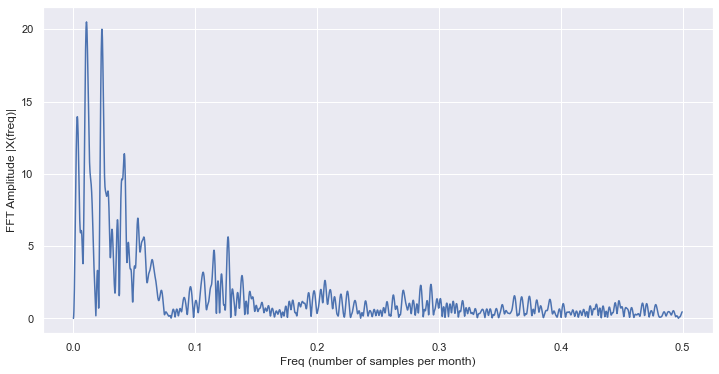

In [20]:
# Padding Zeros
target = np.array(russel_df_m['adjClose_yoy'])
new_target = np.concatenate((target,np.zeros(12*len(target))),axis=0)

fft_y = fft(new_target)
N = len(fft_y)
# Get the sampling rate
sr = 1 # Number of samples per month
T = N / sr # Total number of monthes
n = np.arange(N)
freq = n / T 
# Equivalent to "freq = fftshift(fftfreq(N, 1 / sr))"

# Get the one-sided specturm
n_oneside = N//2
# Get the one side frequency
freq_oneside = freq[:n_oneside]

# Normalization (Not used)
abs_y = np.abs(fft_y)
normalized_y = abs_y / N

plt.figure(figsize = (12, 6))
plt.plot(freq_oneside, abs_y[:n_oneside], 'b')
plt.xlabel('Freq (number of samples per month)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()

C:\Users\11212\AppData\Local\Temp/ipykernel_4236/143699403.py:2: RuntimeWarning: divide by zero encountered in true_divide
  t = 1/freq_oneside


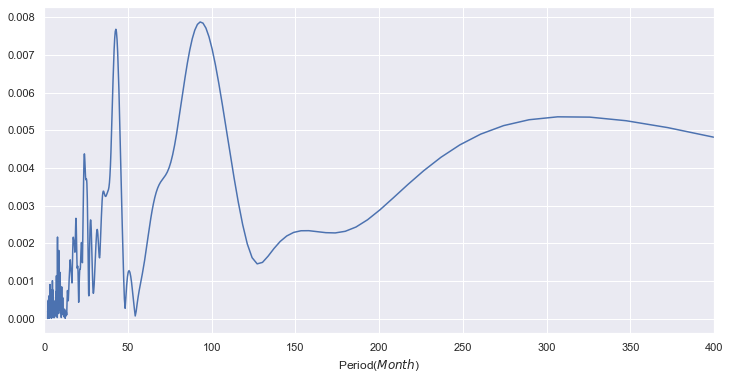

In [23]:
# convert frequency to cycle (or period, number of monthes per sample)
t = 1/freq_oneside 

plt.figure(figsize=(12,6))
plt.plot(t, abs_y[:n_oneside]/n_oneside)
plt.xlim(0, 400)
plt.xlabel('Period($Month$)')
plt.show()

### 傅里叶变换2：先Padding zero增加显示分辨率, 使用freqshift和fftfreq

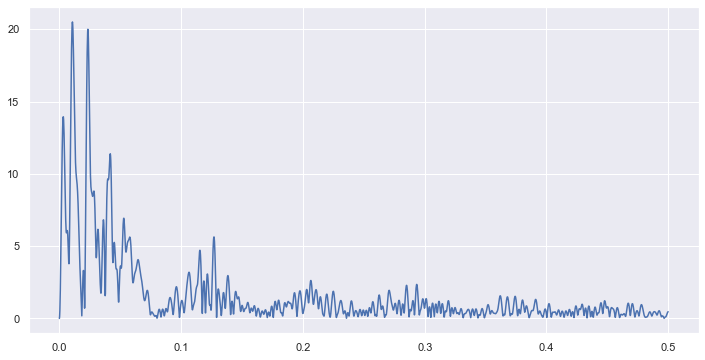

In [24]:
# Padding Zeros
target = np.array(russel_df_m['adjClose_yoy'])
new_target = np.concatenate((target,np.zeros(12*len(target))),axis=0)

# Get the sampling rate
fft_y = fftshift(fft(new_target))
N = len(fft_y)

sr = 1 # Number of samples per month
fft_freq = fftshift(fftfreq(N, 1 / sr))

# Get the one-sided specturm
n_oneside = N//2

plt.figure(figsize = (12, 6))
plt.plot(fft_freq[n_oneside:], np.abs(fft_y)[n_oneside:])
plt.show()

C:\Users\11212\AppData\Local\Temp/ipykernel_4236/3680894860.py:2: RuntimeWarning: divide by zero encountered in true_divide
  t = 1/fft_freq[n_oneside:]


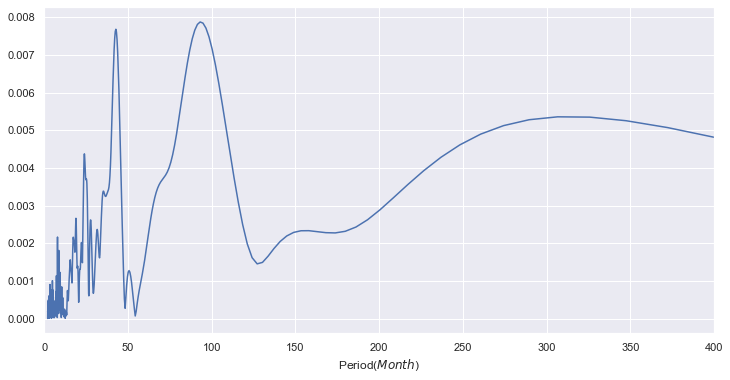

In [25]:
# convert frequency to cycle (number of monthes per sample)
t = 1/fft_freq[n_oneside:] 

plt.figure(figsize=(12,6))
plt.plot(t, np.abs(fft_y)[n_oneside:]/n_oneside)
# plt.xticks([41, 24, 84, 168])
plt.xlim(0, 400)
plt.xlabel('Period($Month$)')
plt.show()